<a href="https://colab.research.google.com/github/wilberquito/AMLProject/blob/main/AMLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project: Image Classification
## Advanced Machine Learning


> Wilber E. Bermeo Quito 
>
> Judit Quintana Massana
>
> April 2023

## 

In [1]:
import zipfile
from pathlib import Path
import torch
import matplotlib.pyplot as plt

/home/wilber/anaconda3/envs/aml-project/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
if IN_COLAB:
    ! pip install torchvision
    from google.colab import drive
    drive.mount('/content/drive')

    data_path = Path('/content/drive/MyDrive/AML/dataset_CIFAR10.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall("data")

    data_path = Path('/content/drive/MyDrive/AML/modular.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall(".")

In [4]:
import modular.datasets as datasets

train_transform, valid_transform = datasets.get_transforms(512)

train_transform, valid_transform

/home/wilber/anaconda3/envs/aml-project/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


(Compose(
     Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
     RandomHorizontalFlip(p=0.5)
     RandomVerticalFlip(p=0.5)
     GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
     RandomRotation(degrees=[30.0, 70.0], interpolation=nearest, expand=False, fill=0)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=warn)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [5]:
import modular.datasets as datasets

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transform,
                                           batch_size=32,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=train_transform,
                                           batch_size=32,
                                           suffle=False)

train_dataloader, validate_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fa3910a9ee0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fa3d47d7610>)

## Visualize images

In [6]:
features, labels = next(iter(train_dataloader))

features.size(), labels.size()

(torch.Size([32, 3, 512, 512]), torch.Size([32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


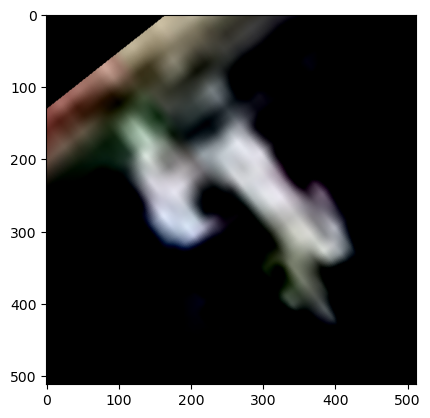

Label: 7


In [7]:
img = features[0].squeeze().permute(1,2,0)
label = labels[0]

plt.imshow(img)
plt.show()
print(f'Label: {label}')

In [8]:
img.permute(1,2,0).shape

torch.Size([512, 3, 512])

In [9]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## AML Resnet50

In [13]:
import modular.models as models

amlresnet50 = models.AMLResnet50(out_dim=10)
amlresnet50 = amlresnet50.to(device=device)

In [14]:
from torchinfo import summary

batch_size = 16
img_size = models.get_img_size(model_id='amlresnet50')
summary(model=amlresnet50, 
        input_size=(32, 3, img_size, img_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
AMLResnet50 (AMLResnet50)                     [32, 3, 232, 232]    [32, 10]             --                   Partial
├─ResNet (net)                                [32, 3, 232, 232]    [32, 2048]           --                   False
│    └─Conv2d (conv1)                         [32, 3, 232, 232]    [32, 64, 116, 116]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 116, 116]   [32, 64, 116, 116]   (128)                False
│    └─ReLU (relu)                            [32, 64, 116, 116]   [32, 64, 116, 116]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 116, 116]   [32, 64, 58, 58]     --                   --
│    └─Sequential (layer1)                    [32, 64, 58, 58]     [32, 256, 58, 58]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 58, 58]     [32, 256, 58,

In [5]:
import torch
import modular.datasets as datasets
import modular.models as models
from pathlib import Path

# Model
amlresnet50 = models.AMLResnet50(out_dim=10)

# Optimizer
optimizer = torch.optim.Adam(params=amlresnet50.parameters(),
                             lr=0.001)

# Criterion
loss = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 10

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('trained/amlresnet50.pth')

# Data augmentation
train_transform, valid_transform = datasets.get_transforms(512)


train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transform,
                                           batch_size=32,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=train_transform,
                                           batch_size=32,
                                           suffle=False)

In [6]:
from modular.engine import train

results = train(model=amlresnet50,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                loss_fn=loss,
                epochs=epochs,
                device=device,
                save_as=save_as)


results

  0%|          | 0/10 [00:12<?, ?it/s]


KeyboardInterrupt: 